# Lab Assignment Three: Extending Logistic Regression

## Catherine Magee, Morgan Mote, Luv Patel 



### In this lab, we will compare the performance of logistic regression optimization programmed in scikit-learn and via our implementation. We will also modify the optimization procedure for logistic regression. 



### Standard Library Imports

In [1]:
from IPython.display import display, HTML, Markdown
import warnings
import textwrap
import os
import sys
import glob
import zipfile
from pathlib import Path
import platform
import subprocess
import copy
from typing import Optional

# Third-Party Imports
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import bokeh
import missingno as mn

# Tensorflow
import tensorflow as tf
from tensorflow import keras

# Sci-py Imports
import scipy
from scipy.special import expit

# Imblearn Imports
from imblearn.over_sampling import SMOTE

# Skimage Imports
import skimage

# Sklearn Imports
import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import pairwise
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)
from sklearn import preprocessing

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# Warning Filters
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="fastai")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#Random number generator seed
np.random.seed(123)

### Read in the dataset

In [2]:
# Dataset Import
#CSV file is in the same directory as Python script
file_path = "COVID-19_cases_plus_census.csv"

# Read the CSV file into a DataFrame
cases = pd.read_csv(file_path)

# Now, 'cases' contains the data from the CSV file

## Dataset Description

We retrieved out dataset from the following source: https://console.cloud.google.com/marketplace/details/usafacts-public-data/covid19-us-cases?filter=solution-type:dataset&filter=category:covid19&id=3eaff9c5-fbaf-47bb-a441-89db1e1395ab&project=still-nebula-398202 [1]

    This is an extension of our exploratory analysis from project one that focuses on COVID 19 data pulled from the Google Cloud Public Datasets Program. More Specifically, this dataset focuses on a census report in Texas that was collected during the pandemic in 2021 and it contains 6366 features and 3142 rows. The purpose of this dataset is to discover which counties in Texas are at highest risk for positive COVID 19 cases. 
    
    The COVID-19 pandemic had a major impact on every facet of the human experience for people all over the world. Businesses closed while people lost their jobs, homes, and loved ones. Through the significant human impact, data collection has allowed analysts to shed light on exactly how the pandemic affected businesses and economies worldwide. On a regulatory front, there were many inconsistencies in public health regulations and guidelines between federal and state agencies. These disparities fueled public health concerns and debates which contributed to an increased sense of confusion and lack of effectiveness of the measures put in place to protect the public from COVID-19 infection. The data was collected to provide an accurate view of the affects of a pandemic in the US so that we may be better prepared to face a pandemic in the future. Therefore this datasets classification task is to label which factors would be associated with positve COVID 19 cases or a higher death per case value.
    
    This analysis is essential to flattening the curve or slowing the spread of postive COVID 19 cases because it surfaces not only the counties that are at the highest risk but also which demographic in that county needs the most assistance. Therefore this analysis can provide useful information to third parties such as hospitals in their distribution of personal protective equipment (PPE) such as masks. In the case of our studies this datset is an offline analysis because it is reviewed after collection not during collection time. In order for this information to be useful to specific hospital locations our classifiers accuracy should be at 60% or above accuracy. 
    
    Through our analysis, we have revealed that some areas of the country have less deaths overall but higher mortality rates from confirmed COVID-19 cases due to many factors such as local population size and density, proximity to an urban area, and many other aspects will be explored. Some areas with a low population have experienced a higher deaths-per-thousand count than large urban areas with a higher number of deaths but a lower count of deaths-per-thousand. The goal of this analysis is to predict which counties will be at the highest risk with the lowest amount of resources in the future. Based on these notions and within a certain degree of accuracy, it may be possible to predict the development in a region given comparable data from other regions.
    
    

# Data Preparation

### Feature Evaluation

In [3]:
def print_df_list_of_features():
    columns = cases.columns.to_list()
    features = "Features: "
    for i, col in enumerate(columns):
        if i > 0:
            features += f', "{col}"'
        else:
            features += f'"{col}"'
    print(features)

print_df_list_of_features()

#print(len(cases.index))

Features: "county_fips_code", "county_name", "state", "state_fips_code", "date", "confirmed_cases", "deaths", "geo_id", "nonfamily_households", "family_households", "median_year_structure_built", "rent_burden_not_computed", "rent_over_50_percent", "rent_40_to_50_percent", "rent_35_to_40_percent", "rent_30_to_35_percent", "rent_25_to_30_percent", "rent_20_to_25_percent", "rent_15_to_20_percent", "rent_10_to_15_percent", "rent_under_10_percent", "total_pop", "male_pop", "female_pop", "median_age", "white_pop", "black_pop", "asian_pop", "hispanic_pop", "amerindian_pop", "other_race_pop", "two_or_more_races_pop", "not_hispanic_pop", "commuters_by_public_transportation", "households", "median_income", "income_per_capita", "housing_units", "vacant_housing_units", "vacant_housing_units_for_rent", "vacant_housing_units_for_sale", "median_rent", "percent_income_spent_on_rent", "owner_occupied_housing_units", "million_dollar_housing_units", "mortgaged_housing_units", "families_with_young_childre

#### Dataset size

In [4]:
def print_df_shape():
    rows, cols = cases.shape
    print(f"~ Dataframe Size ~\nRows: {rows}\nCoumns: {cols}")

print_df_shape()

~ Dataframe Size ~
Rows: 3142
Coumns: 259


#### Calculate rates per 1000 people;  Rate calculation added as new attributes

In [5]:
# Filter rows with confirmed_cases > 0
cases = cases[cases['confirmed_cases'] > 0]

# Calculate rates per 1000 people 
# Rate calculation added as new attributes
cases['cases_per_1000'] = (cases['confirmed_cases'] / cases['total_pop']) * 1000
cases['deaths_per_1000'] = (cases['deaths'] / cases['total_pop']) * 1000
cases['death_per_case'] = cases['deaths'] / cases['confirmed_cases']

# Sort the DataFrame by confirmed_cases in descending order
cases = cases.sort_values(by='confirmed_cases', ascending=False)

### Narrowing dataset to important attributes

In [6]:
# Select important attributes
selected_columns = ['county_name', 'state', 'confirmed_cases', 'deaths', 'total_pop', 'median_income', 
                    'median_age', 'cases_per_1000', 'deaths_per_1000', 'death_per_case', 'female_pop', 'male_pop']
cases = cases[selected_columns]

In [7]:
def get_feature_col_counts():
    cols = ['county_name', 'state', 'confirmed_cases', 'deaths', 'total_pop', 'median_income', 
                    'median_age', 'cases_per_1000', 'deaths_per_1000', 'female_pop', 'male_pop']
    print(f"{' Value Counts '.center(40, '*')}\n")
    for col in cols:
        print(cases[col].value_counts(), "\n")
    print(f"{''.center(40, '*')}")

get_feature_col_counts()

************* Value Counts *************

Washington County      30
Jefferson County       25
Franklin County        24
Lincoln County         23
Jackson County         22
                       ..
Wapello County          1
Webster Parish          1
Carteret County         1
San Patricio County     1
Loving County           1
Name: county_name, Length: 1875, dtype: int64 

TX    254
GA    159
VA    133
KY    120
MO    115
KS    105
IL    102
NC    100
IA     99
TN     95
NE     93
IN     92
OH     88
MN     87
MI     83
MS     82
OK     77
AR     75
WI     72
PA     67
AL     67
FL     67
SD     66
CO     64
LA     64
NY     62
CA     58
MT     56
WV     55
ND     53
SC     46
ID     44
WA     39
OR     36
NM     33
UT     29
AK     27
MD     24
WY     23
NJ     21
NV     17
ME     16
AZ     15
MA     14
VT     14
NH     10
CT      8
RI      5
HI      4
DE      3
DC      1
Name: state, dtype: int64 

1147    5
632     4
114     4
990     4
232     4
       ..
4554    1
4544    1
4543  

In [8]:
# Print the column names in the 'cases' DataFrame
print("These are the cases in the dataframe. \n" + str(cases.columns)+ "\n" + "\n")

# Print the first few rows in the resulting DataFrame
print(cases.head())

These are the cases in the dataframe. 
Index(['county_name', 'state', 'confirmed_cases', 'deaths', 'total_pop',
       'median_income', 'median_age', 'cases_per_1000', 'deaths_per_1000',
       'death_per_case', 'female_pop', 'male_pop'],
      dtype='object')


             county_name state  confirmed_cases  deaths   total_pop  \
287   Los Angeles County    CA          1002614   13936  10105722.0   
832          Cook County    IL           435888    8544   5238541.0   
245      Maricopa County    AZ           425844    6443   4155501.0   
430    Miami-Dade County    FL           347965    4622   2702602.0   
2782       Harris County    TX           286356    3825   4525519.0   

      median_income  median_age  cases_per_1000  deaths_per_1000  \
287         61015.0        36.0       99.212506         1.379021   
832         59426.0        36.4       83.207901         1.630988   
245         58580.0        36.0      102.477174         1.550475   
430         46338.0        39.5      1

### Important Features Description 

|Attribute|Description|
|-------|-----------|
|county_name|Name of each county|
|state|State in the Unites States. |
|confirmed_cases|Total confirmed COVID 19 cases in the county|
|deaths|Total deaths by COVID 19 in the county|
|total_pop|Total population in the county|
|median_income|Middle income value of the county|
|median_age| Middle age value for the county|
|cases_per_1000|Total confirmed cases of COVID-19 in county at time of record (per 1000 people)|
|deaths_per_1000|Total confirmed deaths by COVID-19 in county at time of record (per 1000 people)|
|death_per_case|County specific value of the amount of deaths / confirmed cases |
|male_pop|Total male population in the county|
|female_pop|Total female population in the county|

### Dataset Types


In [9]:
print(cases.dtypes)

county_name         object
state               object
confirmed_cases      int64
deaths               int64
total_pop          float64
median_income      float64
median_age         float64
cases_per_1000     float64
deaths_per_1000    float64
death_per_case     float64
female_pop         float64
male_pop           float64
dtype: object


### Validating the Dataset

#### Check for missing values

In [10]:
missing_values = cases.isnull().sum()
print("Missing Values:")
print(str(missing_values)+ "\n")

print("These are the columns with missing data:" + str(cases.columns[cases.isnull().any()].tolist()))

Missing Values:
county_name        0
state              0
confirmed_cases    0
deaths             0
total_pop          0
median_income      0
median_age         0
cases_per_1000     0
deaths_per_1000    0
death_per_case     0
female_pop         0
male_pop           0
dtype: int64

These are the columns with missing data:[]


#### Check for duplicate data

In [11]:
def check_for_duplicate_entries():
    return cases.duplicated().any()


print(
    "Duplicates Found"
) if check_for_duplicate_entries() is True else print("No Duplicates Found")

No Duplicates Found


#### Visualize Missing Data

<Axes: >

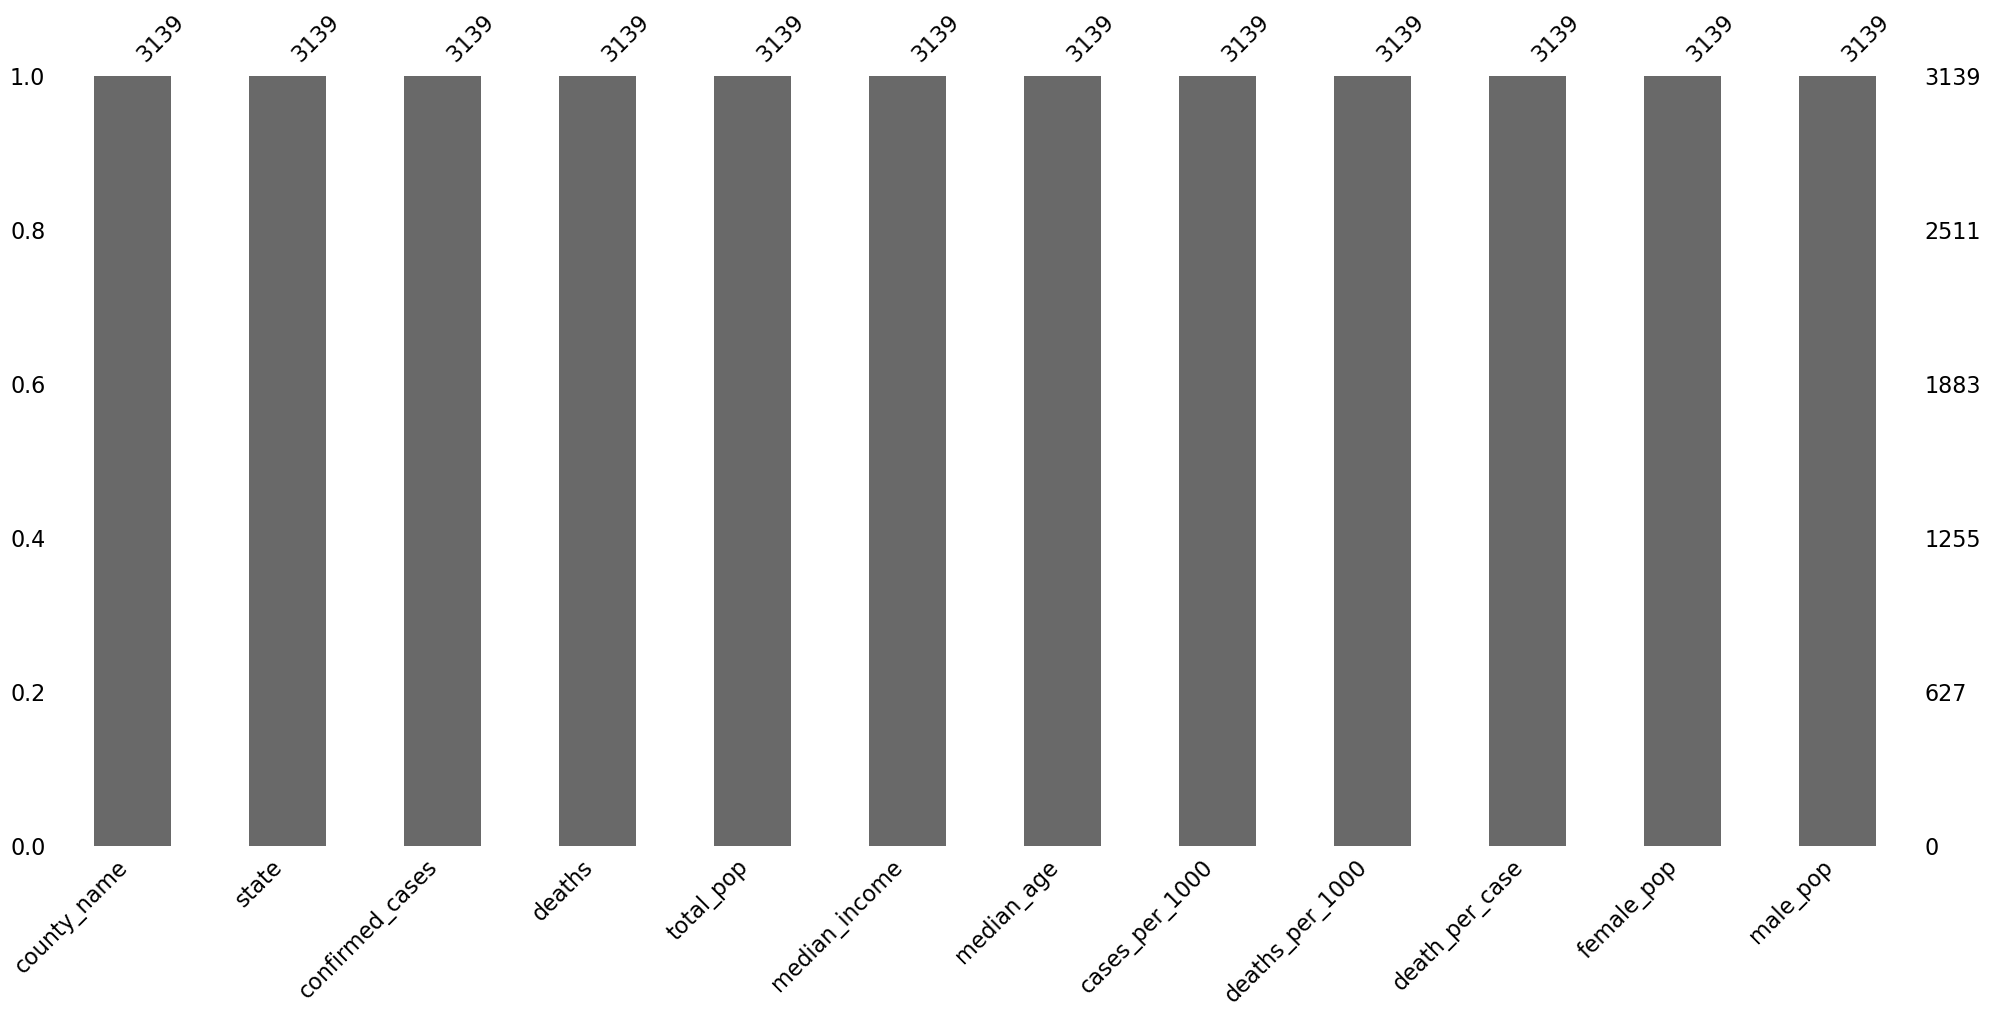

In [12]:
import missingno as msno

msno.bar(cases)

#### Impute missing values using K-Nearest Neighbor for the column BMI

    Since we have no missing data there is no need for imputation. But if we needed to we would use the implementation below or something similar to it. 

In [13]:
#imputer = KNNImputer(n_neighbors=5, weights="uniform")
#bmi_imputed_vals = imputer.fit_transform(cases["#####"].to_numpy().reshape(-1, 1)) # replace with same category from above fuction
#cases["####"] = bmi_imputed_vals # replace with same category from above fuction

# Show that missing values were imputed
#visualize_missing_data("Missing Data Visualized (After Imputation)")

### Identify Categorical Feature Variables

The categorical features are "county_name" and "state". Next we decided to divide the values into discrete vs continuous for the quantitative features Lastly, for the qualitative features in our dataset we decided "county_name" and "state" are nominal. 

Below you can also see that the county name and state are used the same amount in the dataset which also supports that there is no missing values in the dataset. One can also notice that Texas is mentioned much more than Washington County but that is because Texas population is much greater than Washington County. 

In [14]:
cases.describe(exclude=[np.number])

,county_name,state
count,3139,3139
unique,1875,51
top,Washington County,TX
freq,30,254


### Identify Unique County and State Variable

The function below prints all of the unique counties and states featured in the dataset.

In [15]:
def unique_feature_categories():
    print("%s\n" % format(" Unique Categories ".center(50, "*")))

    selected_cols = cases.select_dtypes(exclude=[np.number]).columns.to_list()
    selected_cols = [c for c in selected_cols]

    for col in selected_cols:
        if not isinstance(cases[col].values, float):
            unique_vals = pd.unique(cases[col].values)
            print(
                col, ', '.join([v for v in unique_vals if not isinstance(v, float)]),
                sep=": "
            )
            print()

    print("%s" % format("".center(50, "*")))

unique_feature_categories()

*************** Unique Categories ****************

county_name: Los Angeles County, Cook County, Maricopa County, Miami-Dade County, Harris County, San Bernardino County, Riverside County, Dallas County, San Diego County, Orange County, Clark County, Tarrant County, Broward County, Queens County, Bexar County, Kings County, Suffolk County, Salt Lake County, Nassau County, El Paso County, Bronx County, Milwaukee County, Palm Beach County, Franklin County, Philadelphia County, Middlesex County, Santa Clara County, Hillsborough County, Hennepin County, Wayne County, Pima County, Westchester County, Cuyahoga County, Fresno County, Marion County, Sacramento County, Kern County, Utah County, Mecklenburg County, New York County, Shelby County, Duval County, King County, Essex County, Davidson County, Oklahoma County, DuPage County, Alameda County, St. Louis County, Oakland County, Fairfield County, Providence County, Gwinnett County, Allegheny County, Collin County, Prince George's County, F

### Identify Continuous Feature Variables

In [16]:
cases[ "median_age"].describe(include=[np.number]).round(1) 

count    3139.0
mean       41.1
std         5.4
min        21.6
25%        37.9
50%        41.2
75%        44.2
max        66.4
Name: median_age, dtype: float64

In [17]:
cases[ "confirmed_cases"].describe(include=[np.number]).round(1) 

count       3139.0
mean        7566.1
std        28112.3
min            1.0
25%          798.5
50%         1917.0
75%         4955.5
max      1002614.0
Name: confirmed_cases, dtype: float64

In [18]:
cases["death_per_case"].describe(include=[np.number]).round(1) 

count    3139.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.2
Name: death_per_case, dtype: float64

### View Data Based on Gender and Age

In [19]:
def group_gender_counts():
    gender_tmp = pd.DataFrame({"female_pop": cases["female_pop"], "male_pop": cases["male_pop"]})
    gender_tmp = gender_tmp.reset_index() 
    display(HTML(gender_tmp.to_html()))

group_gender_counts()

,index,female_pop,male_pop
0,287,5126081.0,4979641.0
1,832,2697837.0,2540704.0
2,245,2100037.0,2055464.0
3,430,1390605.0,1311997.0
4,2782,2274459.0,2251060.0
5,299,1066050.0,1055170.0
6,297,1183291.0,1171711.0
7,2775,1294462.0,1257751.0
8,296,1632518.0,1651147.0
9,302,1597571.0,1558245.0


In [20]:
def group_gender_and_age():
    print(cases.columns.tolist())
    age = cases["median_age"].values
    bins = [age for age in range(0, 100, 10)]  # Generator for [0, ..., 90]

    age_binned = pd.cut(age, bins, labels=False)

    tmp_cases = cases.copy()
    tmp_cases["age"] = age_binned

    tmp_cases.rename(
       columns={
            "median_age": "median_age",
            "total_pop": "total_pop",
           "confirmed_cases": "confirmed_cases",
            "median_income": "median_income",
            "deaths_per_1000": "deaths_per_1000"
        },
        inplace=True,
    )
    
    #"gender",

    grouped = (
        tmp_cases.groupby(["age"])
        .agg(
            {
                "median_age": "mean",
                "total_pop": "sum",
                "confirmed_cases": "sum",
                "median_income": "mean",
                "deaths_per_1000": "sum",
            }
        )
        .round(1)
    )
    display(HTML(grouped.to_html()))
    
   

In [21]:
group_gender_and_age()

['county_name', 'state', 'confirmed_cases', 'deaths', 'total_pop', 'median_income', 'median_age', 'cases_per_1000', 'deaths_per_1000', 'death_per_case', 'female_pop', 'male_pop']


,median_age,total_pop,confirmed_cases,median_income,deaths_per_1000
age,,,,,
2,27.5,5250592.0,464352,44422.5,84.9
3,36.6,219179401.0,16821588,52623.3,1577.8
4,43.6,92631946.0,6248417,48299.0,2343.4
5,52.6,3818269.0,209127,46626.3,187.8
6,62.4,122514.0,6624,47304.0,2.2


In [22]:
cases[["female_pop", "male_pop", "death_per_case"]].groupby("female_pop").sum()

,male_pop,death_per_case
female_pop,,
35.0,39.0,0.000000
139.0,150.0,0.000000
211.0,221.0,0.043478
217.0,204.0,0.000000
218.0,235.0,0.090909
...,...,...
1632518.0,1651147.0,0.009812
2100037.0,2055464.0,0.015130
2274459.0,2251060.0,0.013357


In [23]:
cases.groupby('death_per_case').count()

,county_name,state,confirmed_cases,deaths,total_pop,median_income,median_age,cases_per_1000,deaths_per_1000,female_pop,male_pop
death_per_case,,,,,,,,,,,
0.000000,79,79,79,79,79,79,79,79,79,79,79
0.000455,1,1,1,1,1,1,1,1,1,1,1
0.000799,1,1,1,1,1,1,1,1,1,1,1
0.001065,1,1,1,1,1,1,1,1,1,1,1
0.001079,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
0.076923,1,1,1,1,1,1,1,1,1,1,1
0.088608,1,1,1,1,1,1,1,1,1,1,1
0.090909,1,1,1,1,1,1,1,1,1,1,1


### Define Target Features

In [31]:
# Separate the target variable from the rest of the features
target_death_per_case = cases["death_per_case"]
print(cases["death_per_case"])

target_female_pop = cases['female_pop']
print(cases["female_pop"])

target_male_pop = cases['male_pop']
print(cases["male_pop"])

continuous_features = [
    "median_age",
    "confirmed_cases",
    "death_per_case",
]
categorical_features = [
    "county_name",
    "state"
]

287    -0.329019
832     0.182448
245    -0.218657
430    -0.384341
2782   -0.377654
          ...   
365    -1.575879
1678    6.579058
2543   -1.575879
1981   -1.575879
2551   -1.575879
Name: death_per_case, Length: 3139, dtype: float64
287     5126081.0
832     2697837.0
245     2100037.0
430     1390605.0
2782    2274459.0
          ...    
365         436.0
1678        218.0
2543        139.0
1981        255.0
2551         35.0
Name: female_pop, Length: 3139, dtype: float64
287     4979641.0
832     2540704.0
245     2055464.0
430     1311997.0
2782    2251060.0
          ...    
365         384.0
1678        235.0
2543        150.0
1981        291.0
2551         39.0
Name: male_pop, Length: 3139, dtype: float64


### Normalize Continuous Features

In [25]:
scaler = StandardScaler()

In [26]:
cases[continuous_features] = scaler.fit_transform(cases[continuous_features])

### Handling Class Imbalance

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (4979642,).

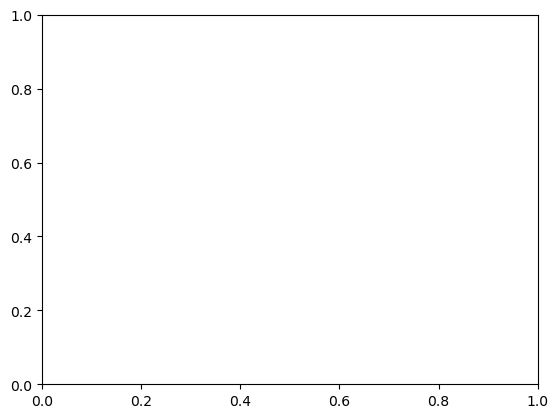

In [30]:
plt.bar([0, 1], np.bincount(target_male_pop))
plt.xticks([0, 1], ['No Confirmation', 'Confirmed'])
plt.title('Class Imbalance For COVID-19 Confirmed Cases Data') 
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (5126082,).

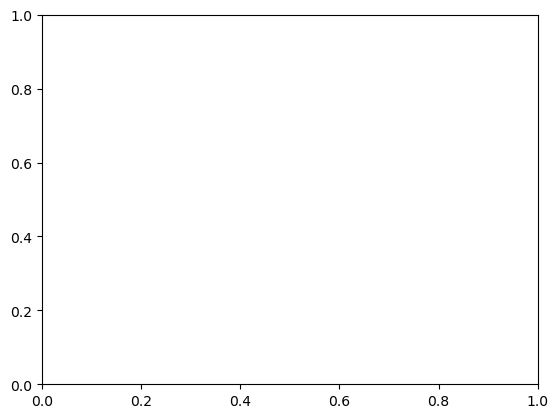

In [32]:
plt.bar([0, 1], np.bincount(target_female_pop))
plt.xticks([0, 1], ['No Confirmation', 'Confirmed'])
plt.title('Class Imbalance For COVID-19 Confirmed Cases Data') 
plt.show()


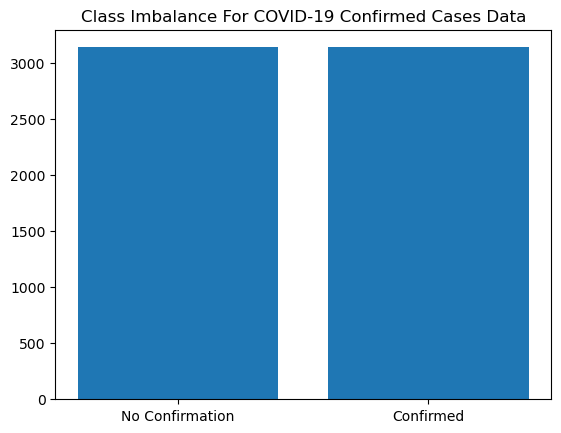

In [28]:
# death_per_case class imbalance check 

plt.bar([0, 1], np.bincount(target_death_per_case))
plt.xticks([0, 1], ['No Confirmation', 'Confirmed'])
plt.title('Class Imbalance For COVID-19 Confirmed Cases Data') 
plt.show()

# please change the attribute for the class imbalance section if it doesnt work

### From the cell above you can tell that there is slim to no class inbalence present in our dataset. So there is no need to resample for a class imbalance. We provided the code below to show how it would be performed if necessary. 

In [40]:
#def resample_for_class_imbalance():
    
    #encoder = LabelEncoder()
    #cases[categorical_features] = cases[categorical_features].apply(
    #lambda ftr: encoder.fit_transform(ftr)
    #)
    #oversample_smote = SMOTE(random_state=123)
    #features = cases[continuous_features]
    #x_resample, y_resample = oversample_smote.fit_resample(features, target)
    #return x_resample, y_resample


#x_resample, y_resample = resample_for_class_imbalance()

In [41]:
#plt.bar([0, 1], np.bincount(y_resample))
#plt.xticks([0, 1], ['No Confirmation', 'Confirmed'])
#plt.title("Class Balance After Using SMOTE")
#plt.show()

In [42]:
#x_resample.shape, y_resample.shape

### View Finalized Preprocessed Dataframe

In [33]:
features = cases[continuous_features]
features.describe().round(2)

,median_age,confirmed_cases,death_per_case
count,3139.00,3139.00,3139.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-3.64,-0.27,-1.58
25%,-0.60,-0.24,-0.65
50%,0.01,-0.20,-0.19
75%,0.57,-0.09,0.48
max,4.70,35.40,14.73


In [34]:
# death_per_case target

target_death_per_case.describe().round(2)

count    3139.00
mean       -0.00
std         1.00
min        -1.58
25%        -0.65
50%        -0.19
75%         0.48
max        14.73
Name: death_per_case, dtype: float64

In [35]:
# death_per_case target

target_female_pop.describe().round(2)

count       3139.00
mean       51922.56
std       167217.54
min           35.00
25%         5478.50
50%        12887.00
75%        34115.00
max      5126081.00
Name: female_pop, dtype: float64

In [36]:
# death_per_case target

target_male_pop.describe().round(2)

count       3139.00
mean       50340.18
std       161254.58
min           39.00
25%         5523.00
50%        12813.00
75%        33537.00
max      4979641.00
Name: male_pop, dtype: float64

#### Overall Statistics 

In [37]:
print(cases.describe())

       confirmed_cases        deaths     total_pop  median_income  \
count      3139.000000   3139.000000  3.139000e+03    3139.000000   
mean          0.000000    124.945524  1.022627e+05   49736.142083   
std           1.000159    481.075014  3.284340e+05   13145.573334   
min          -0.269147      0.000000  7.400000e+01   19264.000000   
25%          -0.240774     12.000000  1.097100e+04   41120.000000   
50%          -0.200981     32.000000  2.571400e+04   48038.000000   
75%          -0.092879     77.000000  6.752450e+04   55758.000000   
max          35.401073  13936.000000  1.010572e+07  129588.000000   

         median_age  cases_per_1000  deaths_per_1000  death_per_case  \
count  3.139000e+03     3139.000000      3139.000000    3.139000e+03   
mean  -7.243507e-16       76.850959         1.336791   -4.527192e-17   
std    1.000159e+00       28.503892         0.922729    1.000159e+00   
min   -3.639002e+00        2.461564         0.000000   -1.575879e+00   
25%   -6.047786e-0

### Split Into Training and Testing Data

In [38]:
# Split the data into training and testing sets
# Divide your data into training and testing data using an 80% training and 20% testing split. 
# Use the cross validation modules that are part of scikit-learn. 
# Argue "for" or "against" splitting your data using an 80/20 split. 
# That is, why is the 80/20 split appropriate (or not) for your dataset?

# Target: female population
x_train_female_pop, x_test_female_pop, y_train_female_pop, y_test_female_pop = train_test_split(
    features,
    target_female_pop,
    test_size=0.2,
    random_state=123) # refer to import cell; makes it random split

# Target: male population
x_train_male_pop, x_test_male_pop, y_train_male_pop, y_test_male_pop = train_test_split(
    features,
    target_male_pop,
    test_size=0.2,
    random_state=123) # refer to import cell; makes it random split

# Target: death_per_case
x_train_death_per_case, x_test_death_per_case, y_train_death_per_case, y_test_death_per_case = train_test_split(
    features,
    target_death_per_case,
    test_size=0.2,
    random_state=123) # refer to import cell; makes it random split

# Modeling

### Initial Logistic Regression Using Sklearn 

[2] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### The cell below is a preprocessing step to allow for proper pipelining. 

### Target: death_per_case

In [51]:
# pre processing to solve the following error: 
# "ValueError: Unknown label type: 'continuous'""

lab = preprocessing.LabelEncoder()
y_train_death_per_case = lab.fit_transform(y_train_death_per_case)
y_test_death_per_case = lab.fit_transform(y_test_death_per_case)

In [52]:
# Combine the preprocessor and the linear regression model into a pipeline

pipeline = Pipeline(steps=[("regressor", LogisticRegression())])

pipeline.fit(x_train_death_per_case, y_train_death_per_case)

# Make predictions on the testing data
y_pred = pipeline.predict(x_test_death_per_case)

In [53]:
# Evaluate the performance of the model on the testing data

score = pipeline.score(x_test_death_per_case, y_test_death_per_case)

accuracy = accuracy_score(y_test_death_per_case, y_pred)
precision = precision_score(y_test_death_per_case, y_pred, pos_label='positive', average='micro')
recall = recall_score(y_test_death_per_case, y_pred,pos_label='positive', average='micro')

f1 = f1_score(y_test_death_per_case, y_pred,pos_label='positive', average='micro')
confusion = confusion_matrix(y_test_death_per_case, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.020700636942675158
Precision: 0.020700636942675158
Recall: 0.020700636942675158
F1 Score: 0.020700636942675158
Confusion Matrix:
[[13  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


### Target: male_pop

In [54]:
# pre processing to solve the following error: 
# "ValueError: Unknown label type: 'continuous'""

lab = preprocessing.LabelEncoder()
y_train_male_pop = lab.fit_transform(y_train_male_pop)
y_test_male_pop = lab.fit_transform(y_test_male_pop)

In [55]:
# Combine the preprocessor and the linear regression model into a pipeline

pipeline = Pipeline(steps=[("regressor", LogisticRegression())])

pipeline.fit(x_train_male_pop, y_train_male_pop)

# Make predictions on the testing data
y_pred = pipeline.predict(x_test_male_pop)

In [60]:
# Evaluate the performance of the model on the testing data

score = pipeline.score(x_test_male_pop, y_test_male_pop)

accuracy = accuracy_score(y_test_male_pop, y_pred)
precision = precision_score(y_test_male_pop, y_pred, pos_label='positive', average='micro')
recall = recall_score(y_test_male_pop, y_pred,pos_label='positive', average='micro')

f1 = f1_score(y_test_male_pop, y_pred,pos_label='positive', average='micro')
confusion = confusion_matrix(y_test_male_pop, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Target: female_pop

In [57]:
# pre processing to solve the following error: 
# "ValueError: Unknown label type: 'continuous'""

lab = preprocessing.LabelEncoder()
y_train_female_pop = lab.fit_transform(y_train_female_pop)
y_test_female_pop = lab.fit_transform(y_test_female_pop)

In [58]:
# Combine the preprocessor and the linear regression model into a pipeline

pipeline = Pipeline(steps=[("regressor", LogisticRegression())])

pipeline.fit(x_train_female_pop, y_train_female_pop)

# Make predictions on the testing data
y_pred = pipeline.predict(x_test_female_pop)

In [59]:
# Evaluate the performance of the model on the testing data

score = pipeline.score(x_test_female_pop, y_test_female_pop)

accuracy = accuracy_score(y_test_female_pop, y_pred)
precision = precision_score(y_test_female_pop, y_pred, pos_label='positive', average='micro')
recall = recall_score(y_test_female_pop, y_pred,pos_label='positive', average='micro')

f1 = f1_score(y_test_female_pop, y_pred,pos_label='positive', average='micro')
confusion = confusion_matrix(y_test_female_pop, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.0015923566878980893
Precision: 0.0015923566878980893
Recall: 0.0015923566878980893
F1 Score: 0.0015923566878980893
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Binary Logistic Regression

[3] https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [ ]:
Binary Logistic Regression
class BinaryLogisticRegressionBase:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with
        # sklearn conventions

    def __str__(self):
        return "Base Binary Logistic Regression Object, Not Trainable"

    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1 / (1 + np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term
    
    def _add_bias(self, X):
        return self._add_intercept(X)

    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

In [ ]:
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Binary Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Binary Logistic Regression Object"

    def _get_gradient(self, X, y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape)  # set gradient to zero
        for (xi, yi) in zip(X, y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi, add_intercept=False)) * xi
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape)

        return gradient / float(len(y))

    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X)  # add bias term
        num_samples, num_features = Xb.shape

        # init weight vector to zeros
        self.w_ = np.zeros((num_features, 1))

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta  # multiply by learning rate

In [ ]:
def run_binary_logistic_regression(**kwargs):
    blr = BinaryLogisticRegression(**kwargs)
    blr.fit(x_train, y_train)
    y_pred = blr.predict(x_test)
    
    print(f"Shape: {blr.w_.shape}")
    print(blr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_binary_logistic_regression(eta=0.1, iterations=24)
run_binary_logistic_regression(eta=0.1, iterations=700)

### Line Search Logistic Regression

[4] https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

In [ ]:
class LineSearchLogisticRegression(BinaryLogisticRegression):

    # define custom line search for problem
    def __init__(self, line_iters=0.0, C=0.005, **kwargs):
        self.line_iters = line_iters
        self.C = C
        # but keep other keywords
        super().__init__(**kwargs)  # call parent initializer

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta, X, y, w, grad, C):
        wnew = w - grad * eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return (
            -np.sum(np.ma.log(g[y == 1]))
            - np.ma.sum(np.log(1 - g[y == 0]))
            + C * sum(wnew**2)
        )


    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb, y)
            # minimization is in opposite direction

            # do line search in gradient direction, using scipy function
            opts = {"maxiter": self.line_iters}  # unclear exactly what this should be
            res = scipy.optimize.minimize_scalar(
                self.objective_function,  # objective function to optimize
                bounds=(0, self.eta * 10),  # bounds to optimize
                args=(
                    Xb,
                    y,
                    self.w_,
                    gradient,
                    self.C,
                ),  # additional argument for objective function
                method="bounded",  # bounded optimization for speed
                options=opts,
            )  # set max iterations

            eta = res.x  # get optimal learning rate
            self.w_ -= gradient * eta  # set new function values
            # subtract to minimize

In [ ]:
def run_line_search_logistic_regression(**kwargs):
    lslr = LineSearchLogisticRegression(**kwargs)
    lslr.fit(x_train, y_train)
    y_pred = lslr.predict(x_test)
    
    print(f"Shape: {lslr.w_.shape}")
    print(lslr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_line_search_logistic_regression(eta=0.1, iterations=24, C=0.005)

### Vectorized Binary Logistic Regression

In [ ]:
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Vector Binary Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Vector Binary Logistic Regression Object"

    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta)) 

    # but overwrite the gradient calculation
    def _get_gradient(self, X, y):
        ydiff = (
            y - self.predict_proba(X, add_intercept=False).ravel()
        )  # get y difference
        gradient = np.mean(
            X * ydiff[:, np.newaxis], axis=0
        )  # make ydiff a column vector and multiply through

        return gradient.reshape(self.w_.shape)

In [ ]:
def run_vectorized_logistic_regression(**kwargs):
    vlr = VectorBinaryLogisticRegression(**kwargs)
    vlr.fit(x_train, y_train)
    y_pred = vlr.predict(x_test)
    
    print(f"Shape: {vlr.w_.shape}")
    print(vlr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

In [ ]:
run_vectorized_logistic_regression(eta=0.1, iterations=24)

In [ ]:
run_vectorized_logistic_regression(eta=0.1, iterations=1000)

### Multi-Class (One-Versus-All) Logistic Regression

[5] https://github.com/mGalarnyk/DSGO_IntroductionScikitLearn/blob/main/notebooks/LogisticOneVsAll.ipynb

In [ ]:
class MCLogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "MultiClass Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained MultiClass Logistic Regression Object"

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers

        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = y == yval  # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta, self.iters)
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            probs.append(
                blr.predict_proba(X)
            )  # get probability for each classifier

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        return self.unique_[
            np.argmax(self.predict_proba(X), axis=1)
        ]  # take argmax along row

In [ ]:
def run_multiclass_logistic_regression(**kwargs):
    mlr = MCLogisticRegression(**kwargs)
    mlr.fit(x_train, y_train)
    y_pred = mlr.predict(x_test)
    
    print(f"Shape: {mlr.w_.shape}")
    print(mlr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

In [ ]:
run_multiclass_logistic_regression(eta=0.1, iterations=10)

In [ ]:
run_multiclass_logistic_regression(eta=0.1, iterations=1000)

In [ ]:
def compare_own_logistic_regression_model_with_scikit_version():
    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    print("***** Scikit-Learn Logistic Regression Model *****")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

compare_own_logistic_regression_model_with_scikit_version()

### Logistic Regression Class Boundaries

In [ ]:
def plot_decision_boundaries(lr, Xin, y, title=""):
    new_x = Xin[['confirmed_cases', 'deaths_per_case']]
    Xb = copy.deepcopy(new_x)
    lr.fit(Xb, y)  # train only on two features

    h = 0.01
    # create a mesh to plot in
    x_min, x_max = Xb.avg_glucose_level.min() - 1, Xb.avg_glucose_level.max() + 1
    y_min, y_max = Xb.bmi.min() - 1, Xb.bmi.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb.avg_glucose_level, Xb.bmi, c=y, cmap=plt.cm.Paired)
    plt.xlabel("Confirmed Cases")
    plt.ylabel("Deaths per Case")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()


mc_lr_model = MCLogisticRegression(eta=0.1, iterations=500)
plot_decision_boundaries(
    mc_lr_model, x_train, y_train, "Logistic Regression Class Boundaries (User-Defined)"
)

In [ ]:
lr_model = LogisticRegression(solver='liblinear')
plot_decision_boundaries(
    lr_model, x_train, y_train, "Logistic Regression Class Boundaries (Sklearn)"
)

### Regularized Binary Logistic Regression

In [ ]:
class RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, C=0.0, **kwargs):
        # need to add to the original initializer
        self.C = C
        # but keep other keywords
        super().__init__(**kwargs)  # call parent initializer

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Regularized Binary Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Regularized Binary Logistic Logistic Regression Object"

    # extend previous class to change functionality
    def _get_gradient(self, X, y, reg="l1+l2"):
        # call get gradient from previous class
        gradient = super()._get_gradient(X, y)


        if reg == "l1":
            # add in regularization (to all except bias term)
            gradient[1:] += -2 * np.sign(self.w_[1:]) * self.C
            return gradient
        
        elif reg == "l2":
            # add in regularization (to all except bias term)
            gradient[1:] += -2 * self.w_[1:] * self.C
            return gradient
        
        if reg == "l1+l2":
            # add in regularization (to all except bias term)
            l1gradient = -2 * np.sign(self.w_[1:]) * self.C
            l2gradient = -2 * self.w_[1:] * self.C
            gradient[1:] += l1gradient
            gradient[1:] += l2gradient
            return gradient

In [ ]:
class RegularizedLogisticRegression(MCLogisticRegression):
    def __init__(self, C=0.0, **kwargs):
        # need to add to the original initializer
        self.C = C
        # but keep other keywords
        super().__init__(**kwargs)  # call parent initializer
    
    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Regularized Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Regularized Logistic Regression Object"

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers

        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = y == yval  # create a binary problem
            # train the binary classifier for this class
            # now this has regularization built into it
            blr = RegularizedBinaryLogisticRegression(
                eta=self.eta, iterations=self.iters, C=self.C
            )
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

In [ ]:
def run_regularized_binary_logistic_regression(**kwargs):
    rblr = RegularizedBinaryLogisticRegression(**kwargs)
    rblr.fit(x_train, y_train)
    y_pred = rblr.predict(x_test)
    
    print(f"Shape: {rblr.w_.shape}")
    print(rblr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_regularized_binary_logistic_regression(C=0.0, eta=0.1, iterations=1000)  

In [ ]:
def run_regularized_logistic_regression(**kwargs):
    rlr = RegularizedLogisticRegression(**kwargs)
    rlr.fit(x_train, y_train)
    y_pred = rlr.predict(x_test)
    
    print(f"Shape: {rlr.w_.shape}")
    print(rlr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_regularized_logistic_regression(C=0.0, eta=0.1, iterations=1000)

### Linear Regression Using Stochastic Gradient Descent

In [ ]:
class StochasticLogisticRegression:
    def __init__(self, eta=0.005, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Stochastic Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Stochastic Logistic Regression Object"

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self, X, y):
        idx = np.random.randint(0, len(y)) # Grab random instance
        # idx = int(np.random.rand() * len(y))  # grab random instance

        y_val = y[idx]
        x_val = self.predict_proba(X[idx], add_bias=False)
        ydiff = y_val - x_val  # get y difference (now scalar)

        gradient = (
            X[idx] * ydiff[:, np.newaxis]
        )  # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient

    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for ctr, _ in enumerate(range(self.iters)):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta  # multiply by learning rate

In [ ]:
def run_stochastic_gradient_descent(**kwargs):
    slr = StochasticLogisticRegression(**kwargs)
    slr.fit(x_train, y_train)
    y_pred = slr.predict(x_test)
    
    print(f"Shape: {slr.w_.shape}")
    print(slr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_stochastic_gradient_descent(C=0.0001, eta=0.005, iterations=8000)

### Steepest Gradient Descent

In [ ]:
class SteepestGradientDescentLogisticRegression:
    def __init__(self, eta=0.005, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Steepest Gradient Descent Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Steepest Gradient Descent Logistic Regression Object"

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self, X, y):
        idx = np.random.randint(0, len(y)) # Grab random instance
        # idx = int(np.random.rand() * len(y))  # grab random instance

        y_val = y[idx]
        x_val = self.predict_proba(X[idx], add_bias=False)
        ydiff = y_val - x_val  # get y difference (now scalar)

        gradient = (
            X[idx] * ydiff[:, np.newaxis]
        )  # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient

    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        # self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros
        self.w_ = np.zeros(num_features)

        # for as many as the max iterations
        for ctr, _ in enumerate(range(self.iters)):
            # gradient = self._get_gradient(Xb, y)
            # self.w_ += gradient * self.eta  # multiply by learning rate

            # Calculate the predicted values
            z = np.dot(Xb, self.w_)
            h = 1 / (1 + np.exp(-z))
            # Calculate the error
            error = h - y
            # Calculate the gradient
            gradient = np.dot(Xb.T, error) / num_samples
            # Update the parameters
            self.w_ = self.w_ - self.eta * gradient

In [ ]:
def run_steepest_gradient_descent(**kwargs):
    sgdlr = SteepestGradientDescentLogisticRegression(**kwargs)
    sgdlr.fit(x_train, y_train)
    y_pred = sgdlr.predict(x_test)
    
    print(f"Shape: {sgdlr.w_.shape}")
    print(sgdlr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_steepest_gradient_descent(C=0.0001, eta=0.005, iterations=8000)

### Hessian Binary Logistic Regression

In [ ]:
class HessianLogisticRegression:
    def __init__(self, eta=0.005, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Hessian Binary Logistic Regression Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Hessian Binary Logistic Regression Object"

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self, X, y):
        g = self.predict_proba(
            X, add_bias=False
        ).ravel()  # get sigmoid value for all classes
        hessian = (
            X.T @ np.diag(g * (1 - g)) @ X - 2 * self.C
        )  # calculate the hessian

        ydiff = y - g  # get y difference
        gradient = np.sum(
            X * ydiff[:, np.newaxis], axis=0
        )  # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return np.linalg.pinv(hessian) @ gradient

    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for ctr, _ in enumerate(range(self.iters)):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta  # multiply by learning rate

In [ ]:
def run_hessian_binary_logistic_regression(**kwargs):
    hblr = HessianLogisticRegression(**kwargs)
    hblr.fit(x_train, y_train)
    y_pred = hblr.predict(x_test)
    
    print(f"Shape: {hblr.w_.shape}")
    print(hblr)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_hessian_binary_logistic_regression(C=0.0001, eta=0.005, iterations=600)

### Hessian Binary Logistic Regression (Rank Two Approximation) From Scratch

In [ ]:
class HessianLogisticRegressionRankTwo:
    def __init__(self, eta=0.005, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Hessian Binary Logistic Regression BFGS Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Hessian Binary Logistic Regression BFGS Object"

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    @staticmethod
    def objective_function(w, X, y, C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return (
            -np.sum(np.ma.log(g[y == 1]))
            - np.sum(np.ma.log(1 - g[y == 0]))
            + C * sum(w**2)
        )
        # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w, X, y, C):
        g = expit(X @ w)
        ydiff = y - g  # get y difference
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient

    @staticmethod
    def backtracking_line_search(f, grad_f, x, p, *args, alpha=1, beta=0.5):
        """Perform a backtracking line search to find a step size that
        satisfies the Armijo condition.

        Parameters
        ----------
        f : callable
            Objective function to minimize.
        grad_f : callable
            Gradient function of the objective function.
        x : array-like
            Current point in the search space.
        p : array-like
            Search direction.
        args : tuple
            Extra arguments to pass to the objective and gradient functions.
        alpha : float, optional
            Initial step size.
        beta : float, optional
            Factor by which to decrease the step size at each iteration.

        Returns
        -------
        float
            Step size that satisfies the Armijo condition.
        """
        while f(x + alpha * p, *args) > f(x, *args) + alpha * beta * np.dot(
            grad_f(x, *args).T, p
        ):
            alpha *= beta
        return alpha

    def bfgs(
        self, f, x0, grad_f, args=(), epsilon=1e-5, max_iterations=10, verbose=False
    ):
        """Minimize a function using the BFGS algorithm.

        Parameters
        ----------
        f : callable
            Objective function to minimize.
        x0 : array-like
            Initial guess for the solution.
        grad_f : callable
            Gradient function of the objective function.
        args : tuple, optional
            Extra arguments to pass to the objective and gradient functions.
        epsilon : float, optional
            Tolerance for the norm of the gradient.
        max_iterations : int, optional
            Maximum number of iterations to perform.
        verbose : bool, optional
            Whether to print information about the optimization process.

        Returns
        -------
        x : ndarray
            The solution found by the optimization algorithm.
        """

        x = x0
        fx = f(x, *args)
        grad_fx = grad_f(x, *args)
        H = np.eye(x0.shape[0])

        for i in range(max_iterations):
            if np.linalg.norm(grad_fx) < epsilon:
                if verbose:
                    print(f"Optimization converged in {i} iterations.")
                return x

            p = -np.dot(H, grad_fx)
            alpha = self.backtracking_line_search(f, grad_f, x, p, *args)
            x_next = x + alpha * p
            s = x_next - x
            y = grad_f(x_next, *args) - grad_fx
            rho = 1 / np.dot(y.T, s)
            H = (np.eye(x.shape[0]) - rho * np.outer(s, y)) @ H @ (
                np.eye(x.shape[0]) - rho * np.outer(y, s)
            ) + rho * np.outer(s, s)
            x = x_next
            fx = f(x, *args)
            grad_fx = grad_f(x, *args)

            if verbose and i % 10 == 0:
                print(
                    f"Iteration {i}: f(x)={fx}, ||grad f(x)||={np.linalg.norm(grad_fx)}"
                )

        if verbose:
            print(f"Optimization stopped after {max_iterations} iterations.")
        return x

    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        # Run bfgs here....
        self.w_ = self.bfgs(
            self.objective_function,
            np.zeros((num_features,)),
            self.objective_gradient,
            args=(Xb, y, self.C),
            epsilon=1e-3,
            max_iterations=self.iters,
            verbose=True,
        )

        self.w_ = self.w_.reshape((num_features, 1))

In [ ]:
def run_hessian_binary_logistic_regression_rank_two(**kwargs):
    hblr2 = HessianLogisticRegressionRankTwo(**kwargs)
    hblr2.fit(x_train, y_train)
    y_pred = hblr2.predict(x_test)
    
    print(f"Shape: {hblr2.w_.shape}")
    print(hblr2)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_hessian_binary_logistic_regression_rank_two(C=0.0001, eta=0.005, iterations=30)

### Hessian Binary Logistic Regression Rank Two (Scipy Version)

In [ ]:
class HessianLogisticRegressionBFGS:
    def __init__(self, eta=0.005, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C

    def __str__(self):
        if hasattr(self, "w_"):
            return (
                "Hessian Binary Logistic Regression BFGS Object with coefficients:\n"
                + str(self.w_)
            )  # is we have trained the object
        else:
            return "Untrained Hessian Binary Logistic Regression BFGS Object"

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    @staticmethod
    def objective_function(w, X, y, C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return (
            -np.sum(np.ma.log(g[y == 1]))
            - np.sum(np.ma.log(1 - g[y == 0]))
            + C * sum(w**2)
        )
        # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w, X, y, C):
        g = expit(X @ w)
        ydiff = y - g  # get y difference
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient

    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return self.predict_proba(X) > 0.5  # return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = scipy.optimize.fmin_bfgs(
            self.objective_function,  # what to optimize
            np.zeros((num_features, 1)),  # starting point
            fprime=self.objective_gradient,  # gradient function
            args=(
                Xb,
                y,
                self.C,
            ),  # extra args for gradient and objective function
            gtol=1e-03,  # stopping criteria for gradient, |v_k|
            maxiter=self.iters,  # stopping criteria iterations
            disp=False,
        )

        self.w_ = self.w_.reshape((num_features, 1))

In [ ]:
def run_hessian_binary_logistic_regression_bfgs(**kwargs):
    hblr_bfgs = HessianLogisticRegressionBFGS(**kwargs)
    hblr_bfgs.fit(x_train, y_train)
    y_pred = hblr_bfgs.predict(x_test)
    
    print(f"Shape: {hblr_bfgs.w_.shape}")
    print(hblr_bfgs)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_hessian_binary_logistic_regression_bfgs(C=0.001, eta=0.005, iterations=3)

### BFGS and Newton's Method for Multiclass Logistic Regression

In [ ]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=HessianLogisticRegressionBFGS):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

In [ ]:
def run_hessian_binary_logistic_regression_bfgs_and_newton(**kwargs):
    hblr_bfgs = MultiClassLogisticRegression(**kwargs)
    hblr_bfgs.fit(x_train, y_train)
    y_pred = hblr_bfgs.predict(x_test)
    
    print(f"Shape: {hblr_bfgs.w_.shape}")
    print(hblr_bfgs)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

run_hessian_binary_logistic_regression_bfgs(C=0.001, eta=0.005, iterations=5)

### Custom Logistic Regression Model Selector

[6] https://www.kaggle.com/code/junkal/selecting-the-best-regression-model

In [ ]:
class ModelSelector:
    models = [
        "Binary",
        "Line Search",
        "Vectorized Binary",
        "Multi-Class",  # One-Versus-All
        "L1 Regularized",
        "L2 Regularized",
        "L1+L2 Regularized",
        "Regularized Multi-Class",
        "Stochastic",
        "Steepest Gradient",
        "Hessian",
        "Hessian Rank Two",
        "Hessian Scipy",
        "Hessian BFGS+Newton Multi-Class",
    ]

    def __init__(
        self,
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_test: Optional[pd.DataFrame] = None,
        y_test: Optional[pd.DataFrame] = None,
    ):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model_name = None
        self.results = []
    
    def model_accuracy(self, model):
        model.fit(self.x_train, self.y_train)
        predictions = model.predict(self.x_test)
        return accuracy_score(self.y_test, predictions)

    def print_models_scores(self):
        print(f"|{''.center(81,'=')}|")
        print(f"|{'MODEL'.center(40, ' ')}|{'ACCURACY'.center(40, ' ')}|")
        print(f"|{''.center(81,'=')}|")
        for name, accuracy in self.results:
            print(f"|{name.center(40, ' ')}|{str(round(accuracy, 4)).center(40, ' ')}|")
        print(f"|{''.center(81,'=')}|")

    def select_model(self, model_name, *args, **kwargs):
        if model_name == "Binary":
            model = self.BinaryLogisticRegression(*args, **kwargs)
        elif model_name == "Line Search":
            model = self.LineSearchLogisticRegression(*args, **kwargs)
        elif model_name == "Vectorized Binary":
            model = self.VectorBinaryLogisticRegression(*args, **kwargs)
        elif model_name == "Multi-Class" or model_name == "One-Versus-All":
            model = self.MCLogisticRegression(*args, **kwargs)
        elif model_name == "L1 Regularized":
            model = self.L1RegularizedBinaryLogisticRegression(*args, **kwargs)
        elif model_name == "L2 Regularized":
            model = self.L2RegularizedBinaryLogisticRegression(*args, **kwargs)
        elif model_name == "L1+L2 Regularized":
            model = self.L1AndL2RegularizedBinaryLogisticRegression(*args, **kwargs)
        elif model_name == "Regularized Multi-Class":
            model = self.MCRegularizedLogisticRegression(*args, **kwargs)
        elif model_name == "Stochastic":
            model = self.StochasticLogisticRegression(*args, **kwargs)
        elif model_name == "Steepest Gradient":
            model = self.SteepestGradientDescentLogisticRegression(*args, **kwargs)
        elif model_name == "Hessian":
            model = self.HessianLogisticRegression(*args, **kwargs)
        elif model_name == "Hessian Rank Two":
            model = self.HessianLogisticRegressionRankTwo(*args, **kwargs)
        elif model_name == "Hessian Scipy":
            model = self.HessianLogisticRegressionBFGS(*args, **kwargs)
        elif model_name == "Hessian BFGS+Newton Multi-Class":
            model = self.MultiClassLogisticRegression(*args, **kwargs)
        else:
            print("Invalid model")

        accuracy = self.model_accuracy(model)
        
        self.model_name = model_name
        self.results.append((model_name, accuracy))

        return model

    class BinaryLogisticRegressionBase:
        def __init__(self, eta, iterations=20, C: Optional[float] = None):
            self.eta = eta
            self.iters = iterations

        def __str__(self):
            return "Base Binary Logistic Regression Object, Not Trainable"

        # convenience, private and static:
        @staticmethod
        def _sigmoid(theta):
            return 1 / (1 + np.exp(-theta))

        @staticmethod
        def _add_intercept(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        def _add_bias(self, X):
            return self._add_intercept(X)

        def predict_proba(self, X, add_intercept=True):
            # add bias term if requested
            Xb = self._add_intercept(X) if add_intercept else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

    class BinaryLogisticRegression(BinaryLogisticRegressionBase):
        def __str__(self):
            if hasattr(self, "w_"):
                return "Binary Logistic Regression Object with coefficients:\n" + str(
                    self.w_
                )  # is we have trained the object
            else:
                return "Untrained Binary Logistic Regression Object"

        def _get_gradient(self, X, y):
            # programming \sum_i (yi-g(xi))xi
            gradient = np.zeros(self.w_.shape)  # set gradient to zero
            for (xi, yi) in zip(X, y):
                # the actual update inside of sum
                gradi = (yi - self.predict_proba(xi, add_intercept=False)) * xi
                # reshape to be column vector and add to gradient
                gradient += gradi.reshape(self.w_.shape)

            return gradient / float(len(y))

        def fit(self, X, y):
            Xb = self._add_intercept(X)  # add bias term
            num_samples, num_features = Xb.shape

            # init weight vector to zeros
            self.w_ = np.zeros((num_features, 1))

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb, y)
                self.w_ += gradient * self.eta  # multiply by learning rate

    class LineSearchLogisticRegression(BinaryLogisticRegression):

        # define custom line search for problem
        def __init__(self, iterations=0.0, C=0.001, **kwargs):
            self.iterations = iterations
            self.C = C
            # but keep other keywords
            super().__init__(**kwargs)  # call parent initializer

        # this defines the function with the first input to be optimized
        # therefore eta will be optimized, with all inputs constant
        @staticmethod
        def objective_function(eta, X, y, w, grad, C):
            wnew = w - grad * eta
            g = expit(X @ wnew)
            # the line search is looking for minimization, so take the negative of l(w)
            return (
                -np.sum(np.ma.log(g[y == 1]))
                - np.ma.sum(np.log(1 - g[y == 0]))
                + C * sum(wnew**2)
            )

        def fit(self, X, y):
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = -self._get_gradient(Xb, y)
                # minimization is in opposite direction

                # do line search in gradient direction, using scipy function
                opts = {
                    "maxiter": self.iterations
                } 
                res = scipy.optimize.minimize_scalar(
                    self.objective_function,  # objective function to optimize
                    bounds=(0, self.eta * 10),  # bounds to optimize
                    args=(
                        Xb,
                        y,
                        self.w_,
                        gradient,
                        self.C,
                    ),  
                    method="bounded",  # bounded optimization for speed
                    options=opts,
                )  # set max iterations

                eta = res.x  # get optimal learning rate
                self.w_ -= gradient * eta  # set new function values

    class VectorBinaryLogisticRegression(BinaryLogisticRegression):
        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Vector Binary Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Vector Binary Logistic Regression Object"

        # inherit from our previous class to get same functionality
        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        # but overwrite the gradient calculation
        def _get_gradient(self, X, y):
            ydiff = (
                y - self.predict_proba(X, add_intercept=False).ravel()
            )  # get y difference
            gradient = np.mean(
                X * ydiff[:, np.newaxis], axis=0
            )  # make ydiff a column vector and multiply through

            return gradient.reshape(self.w_.shape)

    class MCLogisticRegression:
        def __init__(self, eta, iterations=20, **kwargs):
            self.eta = eta
            self.iters = iterations

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "MultiClass Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )
            else:
                return "Untrained MultiClass Logistic Regression Object"

        def fit(self, X, y):
            num_samples, num_features = X.shape
            self.unique_ = np.unique(y)  # get each unique class value
            num_unique_classes = len(self.unique_)
            self.classifiers_ = []  # will fill this array with binary classifiers

            for i, yval in enumerate(self.unique_):  # for each unique value
                y_binary = y == yval  # create a binary problem
                # train the binary classifier for this class
                blr = VectorBinaryLogisticRegression(self.eta, self.iters)
                blr.fit(X, y_binary)
                # add the trained classifier to the list
                self.classifiers_.append(blr)

            # save all the weights into one matrix, separate column for each class
            self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

        def predict_proba(self, X):
            probs = []
            for blr in self.classifiers_:
                probs.append(
                    blr.predict_proba(X)
                )  # get probability for each classifier

            return np.hstack(probs)  # make into single matrix

        def predict(self, X):
            return self.unique_[
                np.argmax(self.predict_proba(X), axis=1)
            ]  # take argmax along row

    class L1RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
        # extend init functions
        def __init__(self, C=0.0, **kwargs):
            # need to add to the original initializer
            self.C = C
            # but keep other keywords
            super().__init__(**kwargs)  # call parent initializer

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Regularized Binary Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return (
                    "Untrained Regularized Binary Logistic Logistic Regression Object"
                )

        # extend previous class to change functionality
        def _get_gradient(self, X, y):
            # call get gradient from previous class
            gradient = super()._get_gradient(X, y)
            gradient[1:] += -2 * np.sign(self.w_[1:]) * self.C
            return gradient

    class L2RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
        # extend init functions
        def __init__(self, C=0.0, **kwargs):
            # need to add to the original initializer
            self.C = C
            # but keep other keywords
            super().__init__(**kwargs)  # call parent initializer

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Regularized Binary Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return (
                    "Untrained Regularized Binary Logistic Logistic Regression Object"
                )

        # extend previous class to change functionality
        def _get_gradient(self, X, y):
            # call get gradient from previous class
            gradient = super()._get_gradient(X, y)
            gradient[1:] += -2 * self.w_[1:] * self.C
            return gradient

    class L1AndL2RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
        # extend init functions
        def __init__(self, C=0.0, **kwargs):
            # need to add to the original initializer
            self.C = C
            # but keep other keywords
            super().__init__(**kwargs)  # call parent initializer

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Regularized Binary Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return (
                    "Untrained Regularized Binary Logistic Logistic Regression Object"
                )

        # extend previous class to change functionality
        def _get_gradient(self, X, y):
            # call get gradient from previous class
            gradient = super()._get_gradient(X, y)
            l1gradient = -2 * np.sign(self.w_[1:]) * self.C
            l2gradient = -2 * self.w_[1:] * self.C
            gradient[1:] += l1gradient
            gradient[1:] += l2gradient
            return gradient

    class MCRegularizedLogisticRegression(MCLogisticRegression):
        def __init__(self, C=0.0, **kwargs):
            # need to add to the original initializer
            self.C = C
            # but keep other keywords
            super().__init__(**kwargs)  # call parent initializer

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Regularized Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Regularized Logistic Regression Object"

        def fit(self, X, y):
            num_samples, num_features = X.shape
            self.unique_ = np.unique(y)  # get each unique class value
            num_unique_classes = len(self.unique_)
            self.classifiers_ = []  # will fill this array with binary classifiers

            for i, yval in enumerate(self.unique_):  # for each unique value
                y_binary = y == yval  # create a binary problem
                # train the binary classifier for this class
                # now this has regularization built into it
                blr = RegularizedBinaryLogisticRegression(
                    eta=self.eta, iterations=self.iters, C=self.C
                )
                blr.fit(X, y_binary)
                # add the trained classifier to the list
                self.classifiers_.append(blr)

            # save all the weights into one matrix, separate column for each class
            self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    class StochasticLogisticRegression:
        def __init__(self, eta=0.005, iterations=20, C=0.001):
            self.eta = eta
            self.iters = iterations
            self.C = C

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Stochastic Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Stochastic Logistic Regression Object"

        @staticmethod
        def _add_bias(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        # vectorized gradient calculation with regularization using L2 Norm
        def _get_gradient(self, X, y):
            idx = np.random.randint(0, len(y))  # Grab random instance
            # idx = int(np.random.rand() * len(y))  # grab random instance

            y_val = y[idx]
            x_val = self.predict_proba(X[idx], add_bias=False)
            ydiff = y_val - x_val  # get y difference (now scalar)

            gradient = (
                X[idx] * ydiff[:, np.newaxis]
            )  # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C

            return gradient

        def predict_proba(self, X, add_bias=True):
            # add bias term if requested
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

        def fit(self, X, y):
            X = X.to_numpy()
            y = y.to_numpy()
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

            # for as many as the max iterations
            for ctr, _ in enumerate(range(self.iters)):
                gradient = self._get_gradient(Xb, y)
                self.w_ += gradient * self.eta  # multiply by learning rate

    class SteepestGradientDescentLogisticRegression:
        def __init__(self, eta=0.005, iterations=20, C=0.001):
            self.eta = eta
            self.iters = iterations
            self.C = C

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Steepest Gradient Descent Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Steepest Gradient Descent Logistic Regression Object"

        @staticmethod
        def _add_bias(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        # vectorized gradient calculation with regularization using L2 Norm
        def _get_gradient(self, X, y):
            idx = np.random.randint(0, len(y))  # Grab random instance
            # idx = int(np.random.rand() * len(y))  # grab random instance

            y_val = y[idx]
            x_val = self.predict_proba(X[idx], add_bias=False)
            ydiff = y_val - x_val  # get y difference (now scalar)

            gradient = (
                X[idx] * ydiff[:, np.newaxis]
            )  # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C

            return gradient

        def predict_proba(self, X, add_bias=True):
            # add bias term if requested
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

        def fit(self, X, y):
            X = X.to_numpy()
            y = y.to_numpy()
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            # self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros
            self.w_ = np.zeros(num_features)

            # for as many as the max iterations
            for ctr, _ in enumerate(range(self.iters)):
                # gradient = self._get_gradient(Xb, y)
                # self.w_ += gradient * self.eta  # multiply by learning rate

                # Calculate the predicted values
                z = np.dot(Xb, self.w_)
                h = 1 / (1 + np.exp(-z))
                # Calculate the error
                error = h - y
                # Calculate the gradient
                gradient = np.dot(Xb.T, error) / num_samples
                # Update the parameters
                self.w_ = self.w_ - self.eta * gradient

    class HessianLogisticRegression:
        def __init__(self, eta=0.005, iterations=20, C=0.001):
            self.eta = eta
            self.iters = iterations
            self.C = C

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Hessian Binary Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Hessian Binary Logistic Regression Object"

        @staticmethod
        def _add_bias(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        # vectorized gradient calculation with regularization using L2 Norm
        def _get_gradient(self, X, y):
            g = self.predict_proba(
                X, add_bias=False
            ).ravel()  # get sigmoid value for all classes
            hessian = (
                X.T @ np.diag(g * (1 - g)) @ X - 2 * self.C
            )  # calculate the hessian

            ydiff = y - g  # get y difference
            gradient = np.sum(
                X * ydiff[:, np.newaxis], axis=0
            )  # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C

            return np.linalg.pinv(hessian) @ gradient

        def predict_proba(self, X, add_bias=True):
            # add bias term if requested
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

        def fit(self, X, y):
            X = X.to_numpy()
            y = y.to_numpy()
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

            # for as many as the max iterations
            for ctr, _ in enumerate(range(self.iters)):
                gradient = self._get_gradient(Xb, y)
                self.w_ += gradient * self.eta  # multiply by learning rate

    class HessianLogisticRegressionRankTwo:
        def __init__(self, eta=0.005, iterations=20, C=0.001):
            self.eta = eta
            self.iters = iterations
            self.C = C

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Hessian Binary Logistic Regression BFGS Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Hessian Binary Logistic Regression BFGS Object"

        @staticmethod
        def _add_bias(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        @staticmethod
        def objective_function(w, X, y, C):
            g = expit(X @ w)
            # invert this because scipy minimizes, but we derived all formulas for maximzing
            return (
                -np.sum(np.ma.log(g[y == 1]))
                - np.sum(np.ma.log(1 - g[y == 0]))
                + C * sum(w**2)
            )
            # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

        @staticmethod
        def objective_gradient(w, X, y, C):
            g = expit(X @ w)
            ydiff = y - g  # get y difference
            gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
            gradient = gradient.reshape(w.shape)
            gradient[1:] += -2 * w[1:] * C
            return -gradient

        @staticmethod
        def backtracking_line_search(f, grad_f, x, p, *args, alpha=1, beta=0.5):
            """Perform a backtracking line search to find a step size that
            satisfies the Armijo condition.

            Parameters
            ----------
            f : callable
                Objective function to minimize.
            grad_f : callable
                Gradient function of the objective function.
            x : array-like
                Current point in the search space.
            p : array-like
                Search direction.
            args : tuple
                Extra arguments to pass to the objective and gradient functions.
            alpha : float, optional
                Initial step size.
            beta : float, optional
                Factor by which to decrease the step size at each iteration.

            Returns
            -------
            float
                Step size that satisfies the Armijo condition.
            """
            while f(x + alpha * p, *args) > f(x, *args) + alpha * beta * np.dot(
                grad_f(x, *args).T, p
            ):
                alpha *= beta
            return alpha

        def bfgs(
            self, f, x0, grad_f, args=(), epsilon=1e-5, max_iterations=10, verbose=False
        ):
            """Minimize a function using the BFGS algorithm.

            Parameters
            ----------
            f : callable
                Objective function to minimize.
            x0 : array-like
                Initial guess for the solution.
            grad_f : callable
                Gradient function of the objective function.
            args : tuple, optional
                Extra arguments to pass to the objective and gradient functions.
            epsilon : float, optional
                Tolerance for the norm of the gradient.
            max_iterations : int, optional
                Maximum number of iterations to perform.
            verbose : bool, optional
                Whether to print information about the optimization process.

            Returns
            -------
            x : ndarray
                The solution found by the optimization algorithm.
            """

            x = x0
            fx = f(x, *args)
            grad_fx = grad_f(x, *args)
            H = np.eye(x0.shape[0])

            for i in range(max_iterations):
                if np.linalg.norm(grad_fx) < epsilon:
                    if verbose:
                        print(f"Optimization converged in {i} iterations.")
                    return x

                p = -np.dot(H, grad_fx)
                alpha = self.backtracking_line_search(f, grad_f, x, p, *args)
                x_next = x + alpha * p
                s = x_next - x
                y = grad_f(x_next, *args) - grad_fx
                rho = 1 / np.dot(y.T, s)
                H = (np.eye(x.shape[0]) - rho * np.outer(s, y)) @ H @ (
                    np.eye(x.shape[0]) - rho * np.outer(y, s)
                ) + rho * np.outer(s, s)
                x = x_next
                fx = f(x, *args)
                grad_fx = grad_f(x, *args)

                if verbose and i % 10 == 0:
                    print(
                        f"Iteration {i}: f(x)={fx}, ||grad f(x)||={np.linalg.norm(grad_fx)}"
                    )

            if verbose:
                print(f"Optimization stopped after {max_iterations} iterations.")
            return x

        def predict_proba(self, X, add_bias=True):
            # add bias term if requested
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

        def fit(self, X, y):
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            # Run bfgs here....
            self.w_ = self.bfgs(
                self.objective_function,
                np.zeros((num_features,)),
                self.objective_gradient,
                args=(Xb, y, self.C),
                epsilon=1e-3,
                max_iterations=self.iters,
                verbose=False,
            )

            self.w_ = self.w_.reshape((num_features, 1))

    class HessianLogisticRegressionBFGS:
        def __init__(self, eta=0.005, iterations=20, C=0.001):
            self.eta = eta
            self.iters = iterations
            self.C = C

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "Hessian Binary Logistic Regression BFGS Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained Hessian Binary Logistic Regression BFGS Object"

        @staticmethod
        def _add_bias(X):
            return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

        @staticmethod
        def _sigmoid(theta):
            # increase stability, redefine sigmoid operation
            return expit(theta)  # 1/(1+np.exp(-theta))

        @staticmethod
        def objective_function(w, X, y, C):
            g = expit(X @ w)
            # invert this because scipy minimizes, but we derived all formulas for maximzing
            return (
                -np.sum(np.ma.log(g[y == 1]))
                - np.sum(np.ma.log(1 - g[y == 0]))
                + C * sum(w**2)
            )
            # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

        @staticmethod
        def objective_gradient(w, X, y, C):
            g = expit(X @ w)
            ydiff = y - g  # get y difference
            gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
            gradient = gradient.reshape(w.shape)
            gradient[1:] += -2 * w[1:] * C
            return -gradient

        def predict_proba(self, X, add_bias=True):
            # add bias term if requested
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)  # return the probability y=1

        def predict(self, X):
            return self.predict_proba(X) > 0.5  # return the actual prediction

        def fit(self, X, y):
            Xb = self._add_bias(X)  # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = scipy.optimize.fmin_bfgs(
                self.objective_function,  # what to optimize
                np.zeros((num_features, 1)),  # starting point
                fprime=self.objective_gradient,  # gradient function
                args=(
                    Xb,
                    y,
                    self.C,
                ),  # extra args for gradient and objective function
                gtol=1e-03,  # stopping criteria for gradient, |v_k|
                maxiter=self.iters,  # stopping criteria iterations
                disp=False,
            )

            self.w_ = self.w_.reshape((num_features, 1))

    class MultiClassLogisticRegression:
        def __init__(
            self, eta, iterations=20, C=0.0001, solver=HessianLogisticRegressionBFGS
        ):
            self.eta = eta
            self.iters = iterations
            self.C = C
            self.solver = solver
            self.classifiers_ = []
            # internally we will store the weights as self.w_ to keep with sklearn conventions

        def __str__(self):
            if hasattr(self, "w_"):
                return (
                    "MultiClass Logistic Regression Object with coefficients:\n"
                    + str(self.w_)
                )  # is we have trained the object
            else:
                return "Untrained MultiClass Logistic Regression Object"

        def fit(self, X, y):
            num_samples, num_features = X.shape
            self.unique_ = np.sort(np.unique(y))  # get each unique class value
            num_unique_classes = len(self.unique_)
            self.classifiers_ = []
            for i, yval in enumerate(self.unique_):  # for each unique value
                y_binary = np.array(y == yval).astype(int)  # create a binary problem
                # train the binary classifier for this class

                hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C)
                hblr.fit(X, y_binary)

                # add the trained classifier to the list
                self.classifiers_.append(hblr)

            # save all the weights into one matrix, separate column for each class
            self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

        def predict_proba(self, X):
            probs = []
            for hblr in self.classifiers_:
                probs.append(
                    hblr.predict_proba(X).reshape((len(X), 1))
                )  # get probability for each classifier

            return np.hstack(probs)  # make into single matrix

        def predict(self, X):
            return np.argmax(self.predict_proba(X), axis=1)  # take argmax along row

In [ ]:
model_selector = ModelSelector(x_train, y_train, x_test, y_test)
model_names = model_selector.models
kwargs = {'eta': 0.005, 'iterations': 500, 'C': 0.001}
for model_name in model_names:
    model = model_selector.select_model(model_name, **kwargs)
model_selector.print_models_scores()

# Deployment

We will be using this section to discuss which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

# Conclusion

In summary, this section will be used to summarize the project goal and how we achieved it, and wrapping up any ideas presented back in the business understanding section.

# References

- [1] https://console.cloud.google.com/marketplace/details/usafacts-public-data/covid19-us-cases?filter=solution-type:dataset&filter=category:covid19&id=3eaff9c5-fbaf-47bb-a441-89db1e1395ab&project=still-nebula-398202

#### PLEASE COPY AND PASTE THE RESOURCES FROM THEIR CURRENT LOCATIONS AND PUT THEM HERE